<a href="https://colab.research.google.com/github/a1837594/geometric/blob/main/3D_RNA_Inverse_Design_with_gRNAde.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 💣 gRNAde Design Notebook

**gRNAde**: **G**eometric Deep Learning pipeline for 3D **RNA** inverse **de**sign.
This notebook provides the following functionality:
- **Ready to use:** Full functional usage of pre-trained gRNAde models for fixed backbone re-design of RNA structures from your own PDB files.
- **Custom constraints:** Add your own design constraints, e.g. fixing key functional nucleotides, conditioning the remaining sequence on conserved nucleotides, biasing sampling.
- **Rank designs:** Evaluation and visualization tools for designed RNA sequences, including metrics for selecting amongst designs: sequence recovery, perplexity, 2D self-consistency score (EternaFold and RibonanzaNet-SS), 3D self-consistency scores (RhoFold), chemical modification self-consistency score (RibonanzaNet).

---

🧬 Tutorial notebook to get started: [gRNAde 101](https://github.com/chaitjo/geometric-rna-design/blob/main/tutorial/tutorial.ipynb) <a target="_blank" href="https://colab.research.google.com/drive/16rXKgbGXBBsHvS_2V84WbfKsJYf9lO4Q">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

✍️ New to 3D RNA modelling? Here's a currated reading + watch list for beginners: [Resources](https://www.chaitjo.com/post/rna-modelling-and-design/)

📄 For more details on the methodology, see the accompanying paper: ['gRNAde: Geometric Deep Learning for 3D RNA inverse design'](https://arxiv.org/abs/2305.14749)
> Chaitanya K. Joshi, Arian R. Jamasb, Ramon Viñas, Charles Harris, Simon Mathis, Alex Morehead, Rishabh Anand, and Pietro Liò. gRNAde: Geometric Deep Learning for 3D RNA inverse design. *ICML Computational Biology Workshop, 2023.*
>
>[PDF](https://arxiv.org/abs/2305.14749) | [Code](https://github.com/chaitjo/geometric-rna-design) | [Tweet](https://twitter.com/chaitjo/status/1662118334412800001) | [Slides](https://www.chaitjo.com/publication/joshi-2023-grnade/gRNAde_slides_CASP_RNA_SIG.pdf)



In [1]:
#@title [Run this cell first] Installation
#@markdown This can take up to 5 minutes when starting for the first time... ☕️

# Clone gRNAde codebase
import os
if not os.path.exists("/content/geometric-rna-design"):
    !git clone --depth 1 https://github.com/chaitjo/geometric-rna-design.git
    %cd /content/geometric-rna-design/

import sys
sys.path.append('/content/geometric-rna-design')

# Install libraries
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Installing PyTorch 2.1.0")
    !pip install -q torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu121
    print("Installing PyTorch Geometric.")
    !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
    !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
    !pip install -q torch-cluster -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
    !pip install -q torch-geometric
    print("Installing other libraries.")
    !pip install -q wandb matplotlib seaborn pandas biopython biotite torchmetrics lovely-tensors pyyaml python-dotenv tqdm cpdb-protein draw_rna MDAnalysis einops ml_collections arnie

# Download RhoFold checkpoint (~500MB)
%cd /content/geometric-rna-design/tools/rhofold/
!gdown https://drive.google.com/uc?id=1To2bjbhQLFx1k8hBOW5q1JFq6ut27XEv

# Install EternaFold for secondary structure prediction
if not os.path.exists("/content/geometric-rna-design/tools/EternaFold"):
    print("Installing EternaFold.")
    %mkdir /content/geometric-rna-design/tools
    %cd /content/geometric-rna-design/tools
    !git clone --depth=1 https://github.com/eternagame/EternaFold.git
    %cd /content/geometric-rna-design/tools/EternaFold/src
    !make --quiet

# (Optional, adds 10 mins to install time) Install ViennaRNA for plotting in design notebook
# if not os.path.exists("/content/geometric-rna-design/tools/ViennaRNA-2.6.4"):
#   print("Installing ViennaRNA.")
#   %cd /content/geometric-rna-design/tools
#   !tar -zxvf ViennaRNA-2.6.4.tar.gz
#   %cd ViennaRNA-2.6.4
#   !./configure
#   !make

# Change directory to gRNAde
%cd /content/geometric-rna-design/

# Set environment variables
os.environ['PROJECT_PATH'] = '/content/geometric-rna-design'
os.environ['ETERNAFOLD'] = '/content/geometric-rna-design/tools/EternaFold'
os.environ['X3DNA'] = '/content/geometric-rna-design/tools/x3dna-v2.4'
os.environ['PATH'] = "/content/geometric-rna-design/tools/x3dna-v2.4/bin:$PATH"

Cloning into 'geometric-rna-design'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (133/133), done.
remote: Total 140 (delta 7), reused 114 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (140/140), 261.34 MiB | 16.12 MiB/s, done.
Resolving deltas: 100% (7/7), done.
Updating files: 100% (123/123), done.
/content/geometric-rna-design
Installing PyTorch 2.1.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 GB 509.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 85.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 9.0 MB/s eta 0:00:00
Installing PyTorch Geometric.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# Import libraries
import os
import time
import random
from datetime import datetime
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F

import lovely_tensors as lt
lt.monkey_patch()

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

from src.data.featurizer import RNAGraphFeaturizer
from src.models import AutoregressiveMultiGNNv1
from src.evaluator import (
    self_consistency_score_eternafold,
    self_consistency_score_ribonanzanet,
    self_consistency_score_ribonanzanet_sec_struct,
    self_consistency_score_rhofold,
    edit_distance
)
from src.data.sec_struct_utils import (
    predict_sec_struct,
    pdb_to_sec_struct,
    dotbracket_to_adjacency
)
from src.data.viz_utlils import print_rna_data, draw_2d_struct, draw_2d_struct_biotite
from draw_rna.draw_utils import seq2col
from src.constants import NUM_TO_LETTER, PROJECT_PATH

from gRNAde import CHECKPOINT_PATH, set_seed

from tools.ribonanzanet.network import RibonanzaNet
from tools.ribonanzanet_sec_struct.network import RibonanzaNetSS
from tools.rhofold.rf import RhoFold
from tools.rhofold.config import rhofold_config

/usr/local/lib/python3.10/dist-packages/Bio/Application/__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [3]:
########################
#@title Design scenario
########################

#@markdown Single state or multi state design?
#@markdown - 1: single state
#@markdown - 2, 3, 5: multi state (number of states)
max_num_conformers = 1 #@param [1, 2, 3, 5]

#@markdown Model checkpoint split:
#@markdown - options include 'all', 'das', 'multi'
#@markdown - unless benchmarking, we recommend using 'all' for general usage
split = 'all' #@param ['all', 'das', 'multi']

#@markdown random seed for reproducibility
seed = 0 #@param {type:"integer"}

# Default model hyperparameters (do not change)
VERSION = 0.3
RADIUS = 0.0
TOP_K = 32
NUM_RBF = 32
NUM_POSENC = 32
NOISE_SCALE = 0.1
NODE_IN_DIM = (15, 4)
NODE_H_DIM = (128, 16)
EDGE_IN_DIM = (131, 3)
EDGE_H_DIM = (64, 4)
NUM_LAYERS = 4
DROP_RATE = 0.5
OUT_DIM = 4
DEFAULT_N_SAMPLES = 16
DEFAULT_TEMPERATURE = 0.1

In [4]:
###############################################
#@title Initialise gRNAde model and featurizer
###############################################

# Set random seed
set_seed(seed)

# Set device (GPU/CPU)
device = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define data featurizer
print(f"Creating RNA graph featurizer for max_num_conformers={max_num_conformers}")
featurizer = RNAGraphFeaturizer(
    split = "test",  # set to 'train' to use noise augmentation
    radius = RADIUS,
    top_k = TOP_K,
    num_rbf = NUM_RBF,
    num_posenc = NUM_POSENC,
    max_num_conformers = max_num_conformers,
    noise_scale = NOISE_SCALE
)
# nucleotide mapping: {'A': 0, 'G': 1, 'C': 2, 'U': 3}

# Initialise model
print(f"Initialising GNN encoder-decoder model")
model = AutoregressiveMultiGNNv1(
    node_in_dim = NODE_IN_DIM,
    node_h_dim = NODE_H_DIM,
    edge_in_dim = EDGE_IN_DIM,
    edge_h_dim = EDGE_H_DIM,
    num_layers = NUM_LAYERS,
    drop_rate = DROP_RATE,
    out_dim = OUT_DIM
)
# Load model checkpoint
model_path = CHECKPOINT_PATH[split][max_num_conformers]
print(f"Loading gRNAde checkpoint: {model_path}")
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
# Transfer model to device in eval mode
model = model.to(device)
model.eval()

#########################################
# Initialise other models for evaluation
#########################################

# Initialise RibonanzaNet for 1D self-consistency score
ribonanza_net = RibonanzaNet(
    os.path.join(PROJECT_PATH, 'tools/ribonanzanet/config.yaml'),
    os.path.join(PROJECT_PATH, 'tools/ribonanzanet/ribonanzanet.pt'),
    device
)
# Transfer model to device in eval mode
ribonanza_net = ribonanza_net.to(device)
ribonanza_net.eval()

# Initialise RibonanzaNetSS for 2D self-consistency score w/ pseudoknots
ribonanza_net_ss = RibonanzaNetSS(
    os.path.join(PROJECT_PATH, 'tools/ribonanzanet_sec_struct/config.yaml'),
    os.path.join(PROJECT_PATH, 'tools/ribonanzanet_sec_struct/ribonanzanet_ss.pt'),
    device
)
# Transfer model to device in eval mode
ribonanza_net_ss = ribonanza_net_ss.to(device)
ribonanza_net_ss.eval()

# Initialise RhoFold for 3D self-consistency score
rhofold = RhoFold(rhofold_config, device)
rhofold_path = os.path.join(PROJECT_PATH, "tools/rhofold/model_20221010_params.pt")
print(f"Loading RhoFold checkpoint: {rhofold_path}")
rhofold.load_state_dict(torch.load(rhofold_path, map_location=torch.device('cpu'))['model'])
# Transfer model to device in eval mode
rhofold = rhofold.to(device)
rhofold.eval()

print()

Using device: cuda:0
Creating RNA graph featurizer for max_num_conformers=1
Initialising GNN encoder-decoder model
Loading gRNAde checkpoint: /content/geometric-rna-design/checkpoints/gRNAde_ARv1_1state_all.h5
Loading RibonanzaNet checkpoint: /content/geometric-rna-design/tools/ribonanzanet/ribonanzanet.pt
Loading RibonanzaNet SS checkpoint: /content/geometric-rna-design/tools/ribonanzanet_sec_struct/ribonanzanet_ss.pt
Loading RhoFold checkpoint: /content/geometric-rna-design/tools/rhofold/model_20221010_params.pt



### Load PDB file and featurize

🚨 **Notes:**
- gRNAde currently does not support other ligands, non-standard nucleotides or non-RNA entities in its input. Your PDB file should be cleared of these. We expect a PDB file format similar to [RNAsolo](https://rnasolo.cs.put.poznan.pl/).
- Nucleotides with missing atoms (usually the P at the 5' or 3' end nucleotide) are currently ignored during design. You could either manually add back missing positions into designs within this notebook ([email Chaitanya](chaitanya.joshi@cl.cam.ac.uk) for a very short piece of code that does this), or delete all the rows for these nucleotides in your input PDB file. We realise this is pesky, and are working on fixing it!


sequence:
	GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
coords_list:
	tensor[68, 3, 3] n=612 (2.4Kb) x∈[-29.815, 28.403] μ=0.052 σ=11.331
sec_struct_list:
	...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))
sec_struct_with_pseudoknot:
	...((((((.(.(((((((..[[.[[)))))))((.{..))((((((]]..]].))))))})))))))
eterna_sec_struct_list:
	....(((.....((((((.........))))))...)))..((((((.......))))))........
ribonanzanet_chem_mod:
	tensor[68, 2] n=136 x∈[5.522e-05, 1.005] μ=0.271 σ=0.276
ribonanzanet_ss_sec_struct:
	...(((((((..((((((......[[.))))))[.....)]((((((]].....))))))..))))))
Featurized PyG Data object:
	 Data(edge_index=[2, 2558], seq=[68], node_s=[68, 1, 15], node_v=[68, 1, 4, 3], edge_s=[2558, 1, 131], edge_v=[2558, 1, 3, 3], mask_confs=[68, 1], mask_coords=[68])


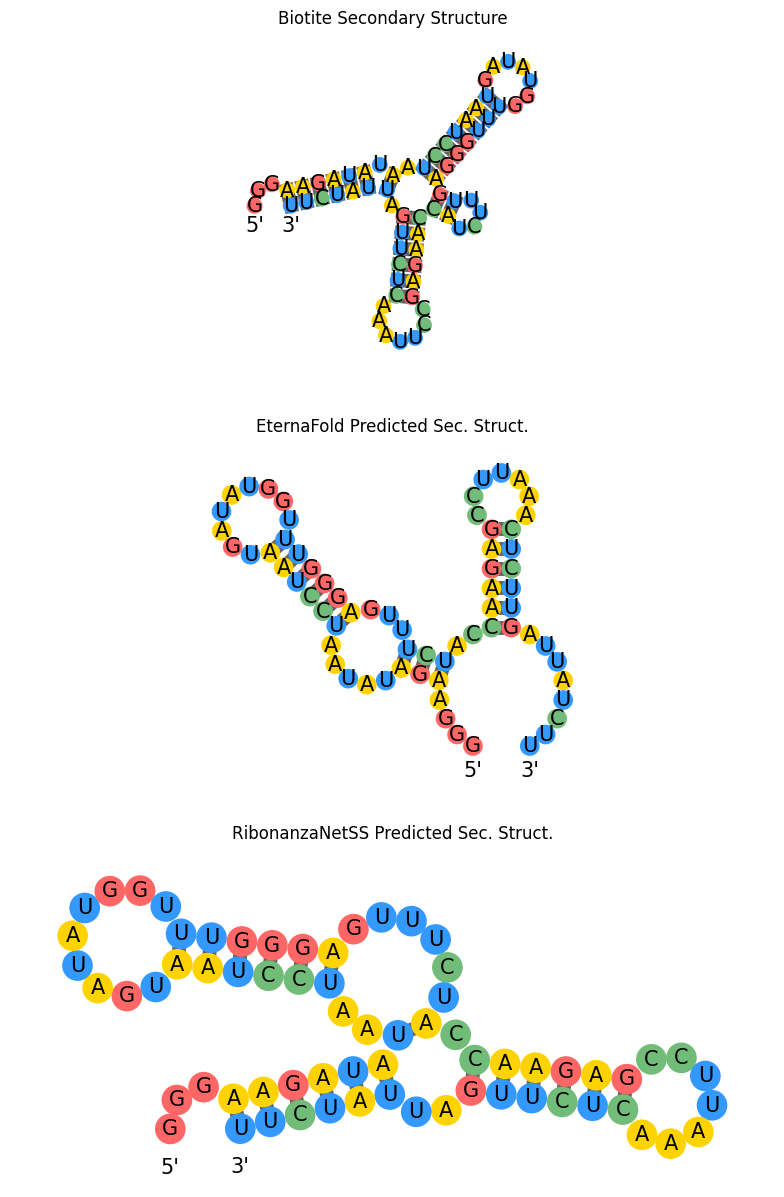

In [5]:
##############################
# Load PDB file and featurize
##############################

#@markdown You can upload a new PDB file and change the path below:
pdb_filepath = os.path.join(PROJECT_PATH, "tutorial/demo_data/adenine_riboswitch/5E54_1_B.pdb")

featurized_data, raw_data = featurizer.featurize_from_pdb_file(pdb_filepath)
# for multi-state design, use: featurize_from_pdb_filelist

# Add secondary structure with pseudoknot
raw_data['sec_struct_with_pseudoknot'] = pdb_to_sec_struct(pdb_filepath, raw_data['sequence'], keep_pseudoknots=True)

# Add predicted secondary structure using EternaFold
raw_data['eterna_sec_struct_list'] = predict_sec_struct(raw_data['sequence'])

# Add predicted chemical modifications using RibonanzaNet
raw_data['ribonanzanet_chem_mod'] = ribonanza_net.predict(raw_data['sequence'])

# Add predicted secondary structure using RibonanzaNet-SS
raw_data['ribonanzanet_ss_sec_struct'] = ribonanza_net_ss.predict(raw_data['sequence'])[1][0]

print_rna_data(raw_data)

print("Featurized PyG Data object:\n\t", featurized_data)

plt.figure(figsize=(15, 15))
ax1 = plt.subplot(3, 1, 1)
plt.title('Biotite Secondary Structure')
try:
    draw_2d_struct_biotite(ax1, raw_data['sequence'], raw_data['sec_struct_with_pseudoknot'], bases_to_color=list(range(len(raw_data['sequence']))))
except:
    draw_2d_struct(raw_data['sequence'], raw_data['sec_struct_list'][0], ax=ax1, large_mode=False)

ax2 = plt.subplot(3, 1, 2)
plt.title('EternaFold Predicted Sec. Struct.')
try:
    draw_2d_struct_biotite(ax2, raw_data['sequence'], raw_data['sec_struct_list'][0], bases_to_color=list(range(len(raw_data['sequence']))))
except:
    draw_2d_struct(raw_data['sequence'], raw_data['eterna_sec_struct_list'][0], ax=ax2, large_mode=False)

ax3 = plt.subplot(3, 1, 3)
plt.title('RibonanzaNetSS Predicted Sec. Struct.')
try:
    draw_2d_struct_biotite(ax3, raw_data['sequence'], raw_data['ribonanzanet_ss_sec_struct'], bases_to_color=list(range(len(raw_data['sequence']))))
except:
    draw_2d_struct(raw_data['sequence'], raw_data['ribonanzanet_ss_sec_struct'], ax=ax3, large_mode=False)

plt.show()

In [6]:
#####################################
#@title Partial sequence constraints
#####################################

print("Raw sequence:        ", raw_data['sequence'])
print("Featurized sequence: ", "".join([featurizer.num_to_letter[num] for num in featurized_data.seq.cpu().numpy()]))
# Sometimes, the first nucleotide is not included in the featurized sequence due to missing Phosphate coordinates.
# In this case, we can add the first nucleotide manually back to designed sequences with very minor post processing.

# Set partial sequence constraints (all _'s are designable positions)
# partial_seq = "".join(["_"]*len(featurized_data.seq))
# print(f"Partial sequence:    ", partial_seq)

#@markdown Add sequence constraints to partial_seq here.
#@markdown For instance, we may want to fix key base pairs based on the secondary structure:
#@markdown - Sequence: `GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU`
#@markdown - 2D struct : `...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))`

#@markdown Set partial sequence constraints (all _'s are designable positions)
partial_seq = '__________________U_______U______GU____AC_____G_______C_____________' #@param {type: 'string'}
print(f"Partial sequence:    ", partial_seq)
print(f"Edit distance after fixing positions: {edit_distance(raw_data['sequence'], partial_seq)}")
#@markdown (If you do not want to add any constraints, just set all positions to '_'s)
# partial_seq = "".join(["_"]*len(featurized_data.seq))

# transfer data to device
featurized_data = featurized_data.to(device)

#@markdown Providing a partial sequence creates a logit bias matrix.
#@markdown You can also manually adjust the bias for more customised constraints.
if partial_seq is not None:
    # convert partial sequence to tensor
    _partial_seq = []
    for residue in partial_seq:
        if residue in featurizer.letter_to_num.keys():
            # fixed nucleotide
            _partial_seq.append(featurizer.letter_to_num[residue])
        else:
            # designable position
            _partial_seq.append(len(featurizer.letter_to_num.keys()))
    _partial_seq = torch.as_tensor(_partial_seq, device=device, dtype=torch.long)
    # convert to one-hot and create bias matrix used during sampling
    logit_bias = F.one_hot(_partial_seq, num_classes=model.out_dim+1).float()

    #########################################################
    # Create final logit_bias matrix for masked sampling
    # - you can manually adjust the bias for more customised
    #   designs and constraints.
    #########################################################
    logit_bias = logit_bias[:, :-1] * 100.0
else:
    logit_bias = None

Raw sequence:         GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
Featurized sequence:  GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
Partial sequence:     __________________U_______U______GU____AC_____G_______C_____________
Edit distance after fixing positions: 60


In [7]:
####################################
#@title Sequence design and scoring
####################################

# Create output directory
current_datetime = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = os.path.join(f"designs/{current_datetime}/")
os.makedirs(output_dir, exist_ok=True)
# Alternatively, you can specify a custom output directory

# collate designed sequences in fasta format
# first record: input sequence and model metadata
input_seq = SeqRecord(
        Seq(raw_data["sequence"]),
        id=f"input_sequence,",
        description=f"checkpoint={os.path.split(model_path)[-1]}, seed={seed}"
    )
sequences = [input_seq]

# collate designed sequences for saving to csv
designs = []

In [8]:
##################################
# Generate designs and score them
##################################

#@markdown Total number of samples to generate
total_samples = 8  #@param {type: 'number'}

#@markdown Number of designed samples (per batch)
n_samples = 8  #@param {type: 'number'}

#@markdown Sampling temperature
#@markdown - Low temperature (eg. 0.1) : more greedy sampling, generally higher sequence recovery
#@markdown - High temperature (eg. 1.0) : more diverse sampling, generally lower sequence recovery
temp = None  #@param
#@markdown (Set as `None` to randomly select a temperature.)
temperatures = [0.2, 0.5, 1.0]

for _ in tqdm(range(total_samples // n_samples)):
    start_time = time.time()

    # Set temperature and seed
    if temp is None:
        temperature = random.choice(temperatures)
    else:
        temperature = temp
    seed = random.randint(0, 999)
    set_seed(seed)

    # sample n_samples from model for single data point: n_samples x seq_len
    samples, logits = model.sample(
        featurized_data, n_samples, temperature, logit_bias, return_logits=True)

    # perplexity per sample: n_samples x 1
    n_nodes = logits.shape[1]
    perplexity = torch.exp(F.cross_entropy(
        logits.view(n_samples * n_nodes, model.out_dim),
        samples.view(n_samples * n_nodes).long(),
        reduction="none"
    ).view(n_samples, n_nodes).mean(dim=1)).cpu().numpy()

    # sequence recovery per sample: n_samples x 1
    recovery = samples.eq(featurized_data.seq).float().mean(dim=1).cpu().numpy()

    # global self consistency score (2D, EternaFold) per sample: n_samples x 1
    sc_score, pred_sec_structs = self_consistency_score_eternafold(
        samples.cpu().numpy(),
        raw_data['sec_struct_list'],
        featurized_data.mask_coords.cpu().numpy(),
        return_sec_structs = True
    )

    # global self consistency score (1D, RibonanzaNet) per sample: n_samples x 1
    sc_score_ribonanza, pred_chem_mods = self_consistency_score_ribonanzanet(
        samples.cpu().numpy(),
        raw_data["sequence"],
        featurized_data.mask_coords.cpu().numpy(),
        ribonanza_net,
        return_chem_mods = True
    )

    # global self consistency score (2D, RibonanzaNet) per sample: n_samples x 1
    sc_score_ribonanza_ss, pred_sec_structs_ribonanza = self_consistency_score_ribonanzanet_sec_struct(
        samples.cpu().numpy(),
        raw_data['sec_struct_with_pseudoknot'],
        featurized_data.mask_coords.cpu().numpy(),
        ribonanza_net_ss,
        return_sec_structs = True
    )

    # global self consistency score (3D, RhoFold) per sample: n_samples x 1
    sc_score_rmsd, sc_score_tm, sc_score_gdt = self_consistency_score_rhofold(
        samples.cpu().numpy(),
        raw_data,
        featurized_data.mask_coords.cpu().numpy(),
        rhofold,
        output_dir,
        save_designs = True,
        save_pdbs = True,
    )

    # clean GPU memory
    torch.cuda.empty_cache()

    # collate designed sequences in fasta and csv format
    start_idx = len(designs)
    for idx, zipped in enumerate(zip(
        samples.cpu().numpy(),
        perplexity,
        recovery,
        sc_score,
        pred_sec_structs,
        sc_score_ribonanza,
        pred_chem_mods,
        sc_score_ribonanza_ss,
        pred_sec_structs_ribonanza,
        sc_score_rmsd,
        sc_score_tm,
        sc_score_gdt
    )):
        seq, perp, rec, sc, pred_ss, sc_ribo, pred_cm, sc_ribo_ss, pred_ss_ribo, sc_rmsd, sc_tm, sc_gdt = zipped
        seq = "".join([NUM_TO_LETTER[num] for num in seq])
        edit_dist = edit_distance(seq, raw_data["sequence"])
        sequences.append(SeqRecord(
            Seq(seq), id=f"sample={start_idx + idx},",
            description=f"{os.path.split(model_path)[-1]} seed={seed} temperature={temperature} perplexity={perp:.4f} recovery={rec:.4f} edit_dist={edit_dist} sc_score={sc:.4f} sc_score_ribonanzanet={sc_ribo:.4f} sc_score_ribonanzanet_ss={sc_ribo_ss:.4f} sc_score_rmsd={sc_rmsd:.4f} sc_score_tm={sc_tm:.4f} sc_score_gdt={sc_gdt:.4f}"
        ))
        designs.append([
            f"sample={start_idx + idx} {os.path.split(model_path)[-1]} seed={seed} temperature={temperature} perplexity={perp:.4f} recovery={rec:.4f} edit_dist={edit_dist} sc_score={sc:.4f} sc_score_ribonanzanet={sc_ribo:.4f} sc_score_ribonanzanet_ss={sc_ribo_ss:.4f} sc_score_rmsd={sc_rmsd:.4f} sc_score_tm={sc_tm:.4f} sc_score_gdt={sc_gdt:.4f}",
            seq, os.path.split(model_path)[-1], seed, temperature, perp, rec, edit_dist, sc, sc_ribo, sc_ribo_ss, sc_rmsd, sc_tm, sc_gdt
        ])

    time_elapsed = time.time() - start_time
    print(f"Generated {n_samples} samples ({len(designs)}/{total_samples}). Time: {time_elapsed:.2f}s")

    # write all currently designed sequences to output filepath
    SeqIO.write(sequences, os.path.join(output_dir, f"all_designs.fasta"), "fasta")
    pd.DataFrame(
        designs,
        columns=["id", "sequence", "model", "seed", "temperature", "perplexity", "recovery", "edit_distance", "sc_score", "sc_score_ribonanzanet", "sc_score_ribonanzanet_ss", "sc_score_rmsd", "sc_score_tm", "sc_score_gdt"]
    ).to_csv(os.path.join(output_dir, f"all_designs.csv"), index=False)

# convert to dataframe
df_designs = pd.DataFrame(
        designs,
        columns=["id", "sequence", "model", "seed", "temperature", "perplexity", "recovery", "edit_distance", "sc_score", "sc_score_ribonanzanet", "sc_score_ribonanzanet_ss", "sc_score_rmsd", "sc_score_tm", "sc_score_gdt"]
    )
# remove duplicates
df_designs = df_designs.drop_duplicates(subset=["sequence"])


  0%|          | 0/1 [00:00<?, ?it/s]

Generated 8 samples (8/8). Time: 23.34s


In [9]:
#######################################
#@title Sequence filtering and ranking
#######################################

# Example: filter designs based on self-consistency score (RibonanzaNet-SS) above 0.75 MCC threshold
df_designs["filter"] = df_designs.apply(lambda x: x["sc_score_ribonanzanet_ss"] >= 0.75, axis=1)
print("Number of designs which pass filter: ", len(df_designs[df_designs["filter"]]))

df_designs[df_designs["filter"]].sort_values(by="edit_distance")

Number of designs which pass filter:  7


,id,sequence,model,seed,temperature,perplexity,recovery,edit_distance,sc_score,sc_score_ribonanzanet,sc_score_ribonanzanet_ss,sc_score_rmsd,sc_score_tm,sc_score_gdt,filter
1,sample=1 gRNAde_ARv1_1state_all.h5 seed=776 te...,GGGGGCAAUCAAUCGUCAUGAUAUGGUUGGCGAGUCUAUACCAAGA...,gRNAde_ARv1_1state_all.h5,776,0.5,1.339595,0.750000,16,0.830014,0.152433,0.815873,1.480942,0.853316,0.849265,True
2,sample=2 gRNAde_ARv1_1state_all.h5 seed=776 te...,GGUACCAUGUAACCUUCAUGAUAUGGUUGGAGGGUAUAUACCAAAA...,gRNAde_ARv1_1state_all.h5,776,0.5,1.397556,0.750000,17,0.856826,0.136402,0.859348,2.299400,0.693957,0.672794,True
4,sample=4 gRNAde_ARv1_1state_all.h5 seed=776 te...,GGUCGAAAACAAUCGUCAUGAUAUGGUUGGCGAGUAUAUACCGAGA...,gRNAde_ARv1_1state_all.h5,776,0.5,1.339716,0.735294,17,0.879363,0.144108,0.859348,2.351536,0.755360,0.779412,True
5,sample=5 gRNAde_ARv1_1state_all.h5 seed=776 te...,GGUUGGACACAAACUUCAUGAUAUGGUUGGAGUGUUUCUACCAGAC...,gRNAde_ARv1_1state_all.h5,776,0.5,1.389007,0.705882,18,0.879363,0.132895,0.838325,3.850846,0.619077,0.591912,True
0,sample=0 gRNAde_ARv1_1state_all.h5 seed=776 te...,GGGGGGGACCAAUCGUCAUGAUAUGGUUGGCGAGUAUAUACCGAGA...,gRNAde_ARv1_1state_all.h5,776,0.5,1.302962,0.720588,19,0.879363,0.159878,0.814893,2.247723,0.743684,0.742647,True
6,sample=6 gRNAde_ARv1_1state_all.h5 seed=776 te...,GGGACGGACCAAUCGUCUUGAUAUGGUAGGCGAGUAUCAACCGAGA...,gRNAde_ARv1_1state_all.h5,776,0.5,1.394057,0.720588,19,0.554147,0.145984,0.814893,4.413041,0.392580,0.419118,True
3,sample=3 gRNAde_ARv1_1state_all.h5 seed=776 te...,GGCUGCACACAAGCGUCAUGAUAUGGUUGGCGCGUAUUAACCGAGA...,gRNAde_ARv1_1state_all.h5,776,0.5,1.333665,0.691176,21,0.856826,0.150892,0.837406,1.982845,0.741303,0.720588,True


>sample=5, gRNAde_ARv1_1state_all.h5 seed=776 temperature=0.5 perplexity=1.3890 recovery=0.7059 edit_dist=18 sc_score=0.8794 sc_score_ribonanzanet=0.1329 sc_score_ribonanzanet_ss=0.8383 sc_score_rmsd=3.8508 sc_score_tm=0.6191 sc_score_gdt=0.5919
GGUUGGACACAAACUUCAUGAUAUGGUUGGAGUGUUUCUACCAGACGCCUUAAACGUCUG
AUUGUCCA

Sample 5
    Designed sequence:    GGUUGGACACAAACUUCAUGAUAUGGUUGGAGUGUUUCUACCAGACGCCUUAAACGUCUGAUUGUCCA
    Groundtruth sequence: GGGAAGAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACCAAGAGCCUUAAACUCUUGAUUAUCUU
    Perplexity: 1.3890
    Recovery: 0.7059
    Edit distance: 18

    Predicted secondary structure:   ...(((((((..((((((.........))))))).......((((((.......))))))..))))))
    Groundtruth secondary structure: ...((((((.(.(((((((.......)))))))((....))((((((.......)))))).)))))))
    SC Score (MCC using EternaFold): 0.8794

    Predicted secondary structure (RibonanzaNet-SS): ...((((((...((((((......[..))))))[.....(]((((((.].....)))))).)))))))
    Groundtruth secondary structure w/

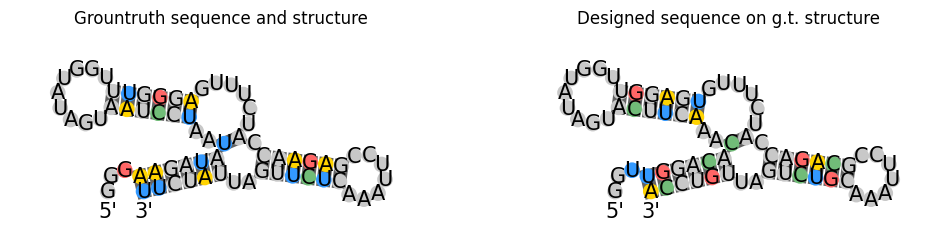

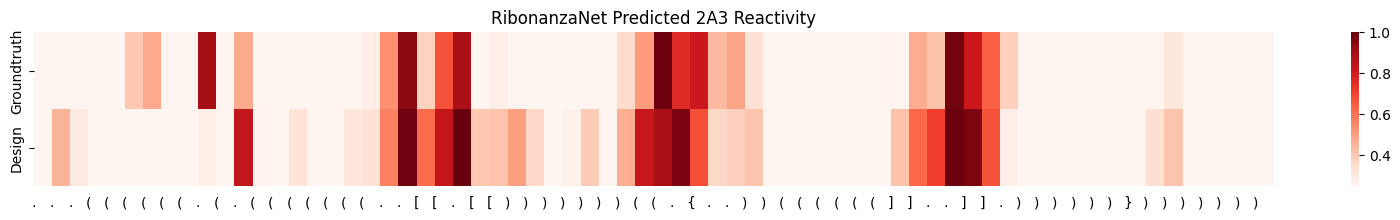

______________________________________________________________________________________________________________________________________________________


In [10]:
#################################
#@title Visualize designed sequences
#################################

#@markdown Select a design to visualize (index in dataframe)
idx = 5  #@param {type: "number"}

reactivity_idx = 0  # 0: 2A3, 1: DMS

id = designs[idx][0]
seq = designs[idx][1]
perp = designs[idx][5]
rec = designs[idx][6]
edit_dist = designs[idx][7]
sc = designs[idx][8]
sc_ribo = designs[idx][9]
sc_ribo_ss = designs[idx][10]
sc_rmsd = designs[idx][11]
sc_tm = designs[idx][12]
sc_gdt = designs[idx][13]

pred_ss = predict_sec_struct(seq)
pred_cm = ribonanza_net.predict(seq)
pred_ss_ribo = ribonanza_net_ss.predict(seq)[1][0]

print(sequences[idx+1].format("fasta"))
print(f"Sample {idx}")
print(f"    Designed sequence:    {seq}")
print(f"    Groundtruth sequence: {raw_data['sequence']}")
print(f"    Perplexity: {perp:.4f}")
print(f"    Recovery: {rec:.4f}")
print(f"    Edit distance: {edit_dist}")
print()
print(f"    Predicted secondary structure:   {pred_ss[0]}")
print(f"    Groundtruth secondary structure: {raw_data['sec_struct_list'][0]}")
print(f"    SC Score (MCC using EternaFold): {sc:.4f}")
print()
print(f"    Predicted secondary structure (RibonanzaNet-SS): {pred_ss_ribo}")
print(f"    Groundtruth secondary structure w/ pseudoknots:  {raw_data['sec_struct_with_pseudoknot']}")
print(f"    SC Score (MCC using RibonanzaNet-SS): {sc_ribo_ss:.4f}")
print()
print(f"    SC Score (RMSD using RhoFold): {sc_rmsd:.4f}")
print(f"    SC Score (TM using RhoFold):   {sc_tm:.4f}")
print(f"    SC Score (GDT using RhoFold):  {sc_gdt:.4f}")
print()
print(f"    SC Score (MAE using RibonanzaNet): {sc_ribo:.4f}")
print()

# plot designed sequence superimposed on groundtruth structure
fig, (ax1, ax2) = plt.subplots(
    1, 2,
    figsize=(12, 8),
    sharex=True,
    sharey=True,
)
ax1.set_title('Grountruth sequence and structure')
try:
    draw_2d_struct_biotite(
        ax1, raw_data['sequence'], raw_data['sec_struct_with_pseudoknot'],
        bases_to_color=[idx for idx, (residue_gt, residue_des) in enumerate(zip(raw_data['sequence'], seq)) if residue_gt != residue_des]
    )
except:
    colors = seq2col(seq)
    colors_gt = seq2col(raw_data['sequence'])
    for i in range(len(colors)):
        if colors[i] == colors_gt[i]:
            colors[i] = 'f'
            colors_gt[i] = 'f'
    draw_2d_struct(raw_data['sequence'], raw_data['ribonanzanet_ss_sec_struct'], c=colors_gt, ax=ax1, large_mode=False)
ax2.set_title('Designed sequence on g.t. structure')
try:
    draw_2d_struct_biotite(
        ax2, seq, raw_data['sec_struct_with_pseudoknot'],
        bases_to_color=[idx for idx, (residue_gt, residue_des) in enumerate(zip(raw_data['sequence'], seq)) if residue_gt != residue_des]
    )
except:
    draw_2d_struct(seq, raw_data['ribonanzanet_ss_sec_struct'], c=colors, ax=ax2, large_mode=False)
plt.show()

# plot predicted and groundtruth chemical modification
plt.figure(figsize=(20, 2))
sns.heatmap(
    pd.DataFrame({
        "Groundtruth": raw_data["ribonanzanet_chem_mod"][:, reactivity_idx].numpy(),
        "Design": pred_cm[:, reactivity_idx].numpy()
    }).transpose(),
    cmap="Reds",
    vmin=0.25,
    vmax=1.0,
)
plt.title(f"RibonanzaNet Predicted {['2A3', 'DMS'][reactivity_idx]} Reactivity")
# replace x-ticks with true secondary structure
plt.xticks(np.arange(len(raw_data["sequence"])), raw_data["sec_struct_with_pseudoknot"])
# rotate x-ticks
plt.xticks(rotation=0)
# remove x-tick marks
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True   # labels along the bottom edge are off
)
plt.show()

###

print("_"*150)